# LoS Detection Strategy 

To detect the level of service (LOS) of a highway from a video of traffic, you would typically follow a series of steps involving video processing, vehicle detection and tracking, and LOS classification. Here's an outline of the process:

1. Video Preprocessing
Frame Extraction: Extract frames from the video at regular intervals, say every 5 seconds.
Stabilization (if necessary): If the video is shaky or moving, apply video stabilization techniques to make it more suitable for analysis.
2. Vehicle Detection and Tracking
Object Detection: Use a deep learning model like YOLO (You Only Look Once), SSD (Single Shot Multibox Detector), or Faster R-CNN to detect vehicles in each frame.
Object Tracking: Implement a tracking algorithm such as SORT (Simple Online and Realtime Tracking) or DeepSORT to track the detected vehicles over multiple frames.
3. Traffic Flow Analysis
Vehicle Count: Count the number of vehicles passing through a defined section of the highway in each 5-second interval.
Speed Estimation: Estimate the speed of each tracked vehicle by measuring the distance covered between frames and knowing the frame rate and camera calibration.
Density Estimation: Calculate the density of vehicles on the highway segment by counting the number of vehicles per unit length of the road.
4. Level of Service (LOS) Classification
Traffic Flow Parameters: The LOS is determined based on parameters like speed, density, and flow (vehicles per hour). Use these metrics to classify the LOS.
- Free Flow (LOS A): Low vehicle density, high speed, and smooth traffic flow.
- Stable Flow (LOS B, C, D): Increasing vehicle density with minor to moderate delays.
- Unstable Flow (LOS E): High vehicle density with frequent stops and low speeds.
- Forced or Breakdown Flow (LOS F): Traffic congestion with very low speeds and frequent stops.
- Classification Model: You can use predefined thresholds for these parameters or train a machine learning model to classify the LOS based on historical data.
5. Output Generation
Time-Series Data: Generate a time series of LOS values every 5 seconds based on the analysis.
Visualization: Create visualizations or reports showing how the LOS changes over time during the video.
Tools and Libraries
OpenCV: For video processing and vehicle detection/tracking.
TensorFlow/PyTorch: For implementing deep learning models for object detection.
Scikit-learn/Pandas: For data analysis and LOS classification.
Custom Scripts: For calculating traffic flow parameters and LOS.
Example Workflow:
Extract Frames: Extract frames at 5-second intervals from the video.
Detect and Track Vehicles: Detect vehicles in each frame and track their movement across frames.
Calculate Traffic Metrics: Compute the speed, count, and density of vehicles.
Classify LOS: Use the calculated metrics to determine the LOS for each 5-second interval.
Generate Output: Produce a report or visual representation of LOS over time.
This approach provides a continuous and dynamic assessment of the highway's level of service using video data.

In [ ]:
!pip install -r requirements.txt
# !mkdir scratch
# !cd scratch
# !git clone https://github.com/kadirnar/sort-pip.git
# !cd sort-pip
# !pip install .


In [ ]:
# Constants
VIDEO_PATH = '../SourceVideo/gdot-camera01.mp4'
# VIDEO_PATH = '../SourceVideo/traffic-simPan.mp4'
FRAME_INTERVAL = 5  # seconds
VIDEO_FPS = 15  # Adjust based on your video
FRAME_SKIP = FRAME_INTERVAL * VIDEO_FPS


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load YOLOv8 model
model = YOLO('yolov8s.pt')  # Replace 'yolov8n.pt' with the specific version you want to use

# Constants
# VIDEO_PATH = 'highway_traffic.mp4'
# FRAME_INTERVAL = 5  # seconds
# VIDEO_FPS = 30  # Adjust based on your video
# FRAME_SKIP = FRAME_INTERVAL * VIDEO_FPS

# Initialize video capture
cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0

def calculate_speed(centroid_prev, centroid_current, fps):
    distance = np.linalg.norm(np.array(centroid_current) - np.array(centroid_prev))
    speed = distance * fps  # Simplified speed calculation
    return speed

def calculate_LOS(vehicle_count, vehicle_speeds):
    avg_speed = np.mean(vehicle_speeds) if vehicle_speeds else 0
    density = vehicle_count / 100  # Simplified assumption of road length
    
    if density < 10 and avg_speed > 60:
        return 'A'
    elif density < 20 and avg_speed > 50:
        return 'B'
    elif density < 30 and avg_speed > 40:
        return 'C'
    elif density < 40 and avg_speed > 30:
        return 'D'
    elif density < 50 and avg_speed > 20:
        return 'E'
    else:
        return 'F'

# Tracking state
tracked_vehicles = {}
los_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue
    
    # Inference
    results = model(frame, verbose=False)
    
    vehicle_count = 0
    vehicle_speeds = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Move tensor to CPU before converting to NumPy
        cls = int(result.cls[0].cpu().numpy())  # Move tensor to CPU before converting to NumPy
        
        if cls in [2, 3, 5, 7]:  # Consider only cars, buses, trucks
            vehicle_count += 1
            centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
            
            # Speed calculation (Simplified)
            if vehicle_count in tracked_vehicles:
                speed = calculate_speed(tracked_vehicles[vehicle_count], centroid, VIDEO_FPS)
                vehicle_speeds.append(speed)
            
            tracked_vehicles[vehicle_count] = centroid
            
            # Draw bounding box and label
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f'Vehicle', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    los = calculate_LOS(vehicle_count, vehicle_speeds)
    los_over_time.append(los)
    
    # Add LOS label to the frame
    cv2.putText(frame, f'LOS: {los}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame in Jupyter Notebook
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

cap.release()

# Output LOS over time
for time, los in enumerate(los_over_time):
    print(f"Time {time * FRAME_INTERVAL}s: LOS {los}")


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import time

# Load YOLOv8 model
model = YOLO('yolov8n.pt')  # Replace 'yolov8n.pt' with the specific version you want to use

# Constants
# VIDEO_PATH = 'highway_traffic.mp4'
FRAME_INTERVAL = 5  # seconds
VIDEO_FPS = 30  # Adjust based on your video
FRAME_SKIP = FRAME_INTERVAL * VIDEO_FPS

# Initialize video capture
cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0

def calculate_speed(centroid_prev, centroid_current, fps):
    distance = np.linalg.norm(np.array(centroid_current) - np.array(centroid_prev))
    speed = distance * fps  # Simplified speed calculation
    return speed

def calculate_LOS(vehicle_count, vehicle_speeds):
    avg_speed = np.mean(vehicle_speeds) if vehicle_speeds else 0
    density = vehicle_count / 100  # Simplified assumption of road length
    
    if density < 10 and avg_speed > 60:
        return 'A'
    elif density < 20 and avg_speed > 50:
        return 'B'
    elif density < 30 and avg_speed > 40:
        return 'C'
    elif density < 40 and avg_speed > 30:
        return 'D'
    elif density < 50 and avg_speed > 20:
        return 'E'
    else:
        return 'F'

# Tracking state
tracked_vehicles = {}
los_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue
    
    # Inference
    results = model(frame, verbose=False)
    
    vehicle_count = 0
    vehicle_speeds = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Move tensor to CPU before converting to NumPy
        cls = int(result.cls[0].cpu().numpy())  # Move tensor to CPU before converting to NumPy
        
        if cls in [2, 3, 5, 7]:  # Consider only cars, buses, trucks
            vehicle_count += 1
            centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
            
            # Speed calculation (Simplified)
            if vehicle_count in tracked_vehicles:
                speed = calculate_speed(tracked_vehicles[vehicle_count], centroid, VIDEO_FPS)
                vehicle_speeds.append(speed)
            
            tracked_vehicles[vehicle_count] = centroid
            
            # Draw bounding box and label
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f'Vehicle', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    los = calculate_LOS(vehicle_count, vehicle_speeds)
    los_over_time.append(los)
    
    # Add LOS label to the frame
    cv2.putText(frame, f'LOS: {los}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame in Jupyter Notebook
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
    
    # Wait for the actual time interval (5 seconds)
    time.sleep(FRAME_INTERVAL)

cap.release()

# Output LOS over time
for time, los in enumerate(los_over_time):
    print(f"Time {time * FRAME_INTERVAL}s: LOS {los}")


# Streaming version

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import time

# Load YOLOv8 model
model = YOLO('yolov8s.pt')  # Replace 'yolov8n.pt' with the specific version you want to use

# Constants
FRAME_INTERVAL = 5  # seconds
VIDEO_FPS = 15  # Estimated FPS for the stream; adjust as necessary
FRAME_SKIP = FRAME_INTERVAL * VIDEO_FPS

# Initialize video capture for webcam (use 0 for the default webcam)
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('http://cvstreamer-cvdemo.apps.ocp4.davenet.local/stream/gdot-cameraC01.m3u8')
frame_count = 0

def calculate_speed(centroid_prev, centroid_current, fps):
    distance = np.linalg.norm(np.array(centroid_current) - np.array(centroid_prev))
    speed = distance * fps  # Simplified speed calculation
    return speed

def calculate_LOS(vehicle_count, vehicle_speeds):
    avg_speed = np.mean(vehicle_speeds) if vehicle_speeds else 0
    density = vehicle_count / 100  # Simplified assumption of road length
    
    if density < 10 and avg_speed > 60:
        return 'A'
    elif density < 20 and avg_speed > 50:
        return 'B'
    elif density < 30 and avg_speed > 40:
        return 'C'
    elif density < 40 and avg_speed > 30:
        return 'D'
    elif density < 50 and avg_speed > 20:
        return 'E'
    else:
        return 'F'

# Tracking state
tracked_vehicles = {}
los_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue
    
    # Inference
    results = model(frame, verbose=False)
    
    vehicle_count = 0
    vehicle_speeds = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Move tensor to CPU before converting to NumPy
        cls = int(result.cls[0].cpu().numpy())  # Move tensor to CPU before converting to NumPy
        
        if cls in [2, 3, 5, 7]:  # Consider only cars, buses, trucks
            vehicle_count += 1
            centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
            
            # Speed calculation (Simplified)
            if vehicle_count in tracked_vehicles:
                speed = calculate_speed(tracked_vehicles[vehicle_count], centroid, VIDEO_FPS)
                vehicle_speeds.append(speed)
            
            tracked_vehicles[vehicle_count] = centroid
            
            # Draw bounding box and label
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f'Vehicle', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    los = calculate_LOS(vehicle_count, vehicle_speeds)
    los_over_time.append(los)
    
    # Add LOS label to the frame
    cv2.putText(frame, f'LOS: {los}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame in Jupyter Notebook
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
    
    # Wait for the actual time interval (5 seconds)
    time.sleep(FRAME_INTERVAL)

cap.release()

# Output LOS over time
for time, los in enumerate(los_over_time):
    print(f"Time {time * FRAME_INTERVAL}s: LOS {los}")


# Newer Version with mqtt storage

In [ ]:
!pip install paho-mqtt

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import time
import paho.mqtt.client as mqtt
import json
import base64

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Initialize MQTT client
mqtt_client = mqtt.Client()
mqtt_client.connect('mqtt-broker.trafficcounter.svc.cluster.local', 1883, 60)  # Use your service name and port

# Constants
FRAME_INTERVAL = 5  # seconds
VIDEO_FPS = 15  # Estimated FPS for the stream; adjust as necessary
FRAME_SKIP = FRAME_INTERVAL * VIDEO_FPS
ROAD_LENGTH = 400  # Example road length in meters

# Initialize video capture
cap = cv2.VideoCapture('http://cv-streamer-trafficcounter.apps.ocpbare.davenet.local/stream/gdot-cameraC01.m3u8')
frame_count = 0

def calculate_speed(centroid_prev, centroid_current, fps):
    distance = np.linalg.norm(np.array(centroid_current) - np.array(centroid_prev))
    speed = distance * fps  # Simplified speed calculation
    return speed

def calculate_density(vehicle_count, road_length=400, vehicle_types=None):
    density = vehicle_count / road_length  # Use actual road length
    
    # Adjust density based on vehicle types (if provided)
    if vehicle_types:
        vehicle_type_weights = {'car': 1.0, 'truck': 2.0, 'bus': 2.5}  # Example weights
        weighted_count = sum(vehicle_type_weights.get(v_type, 1.0) for v_type in vehicle_types)
        density = weighted_count / road_length
    
    return density

# Tracking state
tracked_vehicles = {}
density_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue
    
    # Inference
    results = model(frame, verbose=False)
    
    vehicle_count = 0
    vehicle_speeds = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Move tensor to CPU before converting to NumPy
        cls = int(result.cls[0].cpu().numpy())  # Move tensor to CPU before converting to NumPy
        
        if cls in [2, 3, 5, 7]:  # Consider only cars, buses, trucks
            vehicle_count += 1
            centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
            
            # Speed calculation (Simplified)
            if vehicle_count in tracked_vehicles:
                speed = calculate_speed(tracked_vehicles[vehicle_count], centroid, VIDEO_FPS)
                vehicle_speeds.append(speed)
            
            tracked_vehicles[vehicle_count] = centroid
            
            # Draw bounding box and label
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f'Vehicle', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    density = calculate_density(vehicle_count, ROAD_LENGTH)
    density_over_time.append(density)
    
    # Add Density label to the frame
    cv2.putText(frame, f'Density: {density:.2f} vehicles/m', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Encode the frame as JPEG and then as a base64 string
    _, buffer = cv2.imencode('.jpg', frame)
    image_base64 = base64.b64encode(buffer).decode('utf-8')

    # Prepare data to publish to MQTT
    data = {
        'frame': frame_count,
        'second': frame_count // VIDEO_FPS,
        'density': density,
        'image': image_base64
    }
    
    # Publish to MQTT topic
    mqtt_client.publish('traffic/density', json.dumps(data))
    
    # Display the frame (optional)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
    
    # Wait for the actual time interval (5 seconds)
    time.sleep(FRAME_INTERVAL)

cap.release()

# Output Density over time
for time, density in enumerate(density_over_time):
    print(f"Time {time * FRAME_INTERVAL}s: Density {density:.2f} vehicles/m")


# Plot the density over time

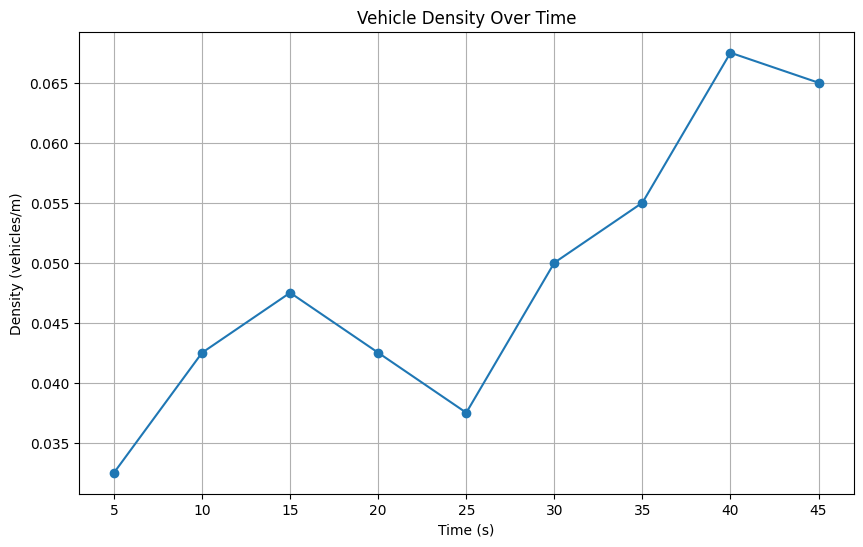

<Figure size 640x480 with 0 Axes>

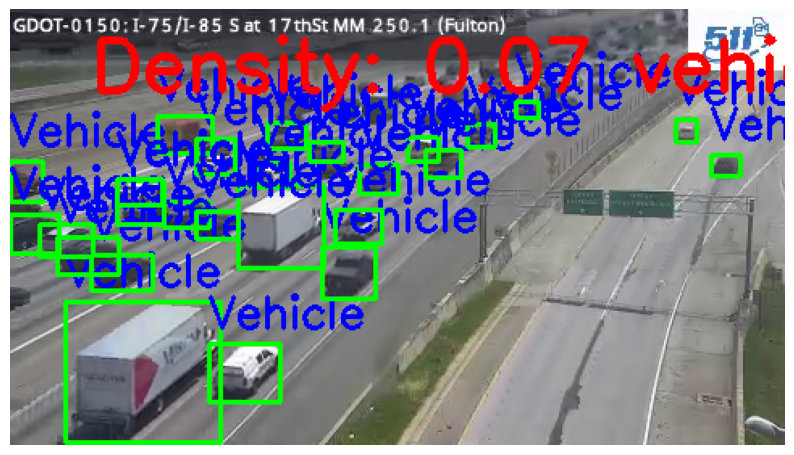

KeyboardInterrupt: 

In [28]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import time
import paho.mqtt.client as mqtt
import json
import base64
from io import BytesIO
from IPython.display import display, clear_output

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Initialize MQTT client
mqtt_client = mqtt.Client()
mqtt_client.connect('mqtt-broker.trafficcounter.svc.cluster.local', 1883, 60)  # Use your service name and port

# Constants
FRAME_INTERVAL = 5  # seconds
VIDEO_FPS = 15  # Estimated FPS for the stream; adjust as necessary
FRAME_SKIP = FRAME_INTERVAL * VIDEO_FPS
ROAD_LENGTH = 400  # Example road length in meters

# Initialize video capture
cap = cv2.VideoCapture('http://cv-streamer-trafficcounter.apps.ocpbare.davenet.local/stream/gdot-cameraC01.m3u8')
frame_count = 0

def calculate_speed(centroid_prev, centroid_current, fps):
    distance = np.linalg.norm(np.array(centroid_current) - np.array(centroid_prev))
    speed = distance * fps  # Simplified speed calculation
    return speed

def calculate_density(vehicle_count, road_length=400, vehicle_types=None):
    density = vehicle_count / road_length  # Use actual road length
    
    # Adjust density based on vehicle types (if provided)
    if vehicle_types:
        vehicle_type_weights = {'car': 1.0, 'truck': 2.0, 'bus': 2.5}  # Example weights
        weighted_count = sum(vehicle_type_weights.get(v_type, 1.0) for v_type in vehicle_types)
        density = weighted_count / road_length
    
    return density

# Tracking state
tracked_vehicles = {}
density_over_time = []

# Set up the plot for density
fig, ax = plt.subplots(figsize=(10, 6))

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue
    
    # Inference
    results = model(frame, verbose=False)
    
    vehicle_count = 0
    vehicle_speeds = []
    
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Move tensor to CPU before converting to NumPy
        cls = int(result.cls[0].cpu().numpy())  # Move tensor to CPU before converting to NumPy
        
        if cls in [2, 3, 5, 7]:  # Consider only cars, buses, trucks
            vehicle_count += 1
            centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
            
            # Speed calculation (Simplified)
            if vehicle_count in tracked_vehicles:
                speed = calculate_speed(tracked_vehicles[vehicle_count], centroid, VIDEO_FPS)
                vehicle_speeds.append(speed)
            
            tracked_vehicles[vehicle_count] = centroid
            
            # Draw bounding box and label
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f'Vehicle', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    density = calculate_density(vehicle_count, ROAD_LENGTH)
    current_time = frame_count // VIDEO_FPS
    density_over_time.append((current_time, density))  # Store time (in seconds) and density
    
    # Add Density label to the frame
    cv2.putText(frame, f'Density: {density:.2f} vehicles/m', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
    
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Encode the frame as JPEG and then as a base64 string
    _, buffer = cv2.imencode('.jpg', frame)
    image_base64 = base64.b64encode(buffer).decode('utf-8')

    # Update the plot dynamically
    ax.clear()
    times, densities = zip(*density_over_time)  # Unpack the list of tuples into two lists
    ax.plot(times, densities, marker='o')
    ax.set_title('Vehicle Density Over Time')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Density (vehicles/m)')
    ax.grid(True)
    
    # Save the plot to a bytes buffer and encode as base64
    plot_buffer = BytesIO()
    plt.savefig(plot_buffer, format='png')
    plot_buffer.seek(0)
    plot_base64 = base64.b64encode(plot_buffer.getvalue()).decode('utf-8')
    plot_buffer.close()
    
    clear_output(wait=True)  # Clear the previous plot in the notebook
    display(fig)  # Display the updated plot
    
    # Prepare data to publish to MQTT
    data = {
        'frame': frame_count,
        'second': current_time,
        'density': density,
        'image': image_base64,
        'plot': plot_base64
    }
    
    # Publish to MQTT topic
    mqtt_client.publish('traffic/density', json.dumps(data))
    
    # Display the frame (optional)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
    
    # Wait for the actual time interval (5 seconds)
    time.sleep(FRAME_INTERVAL)

cap.release()

# Keep the final plot displayed
plt.show()
